# <center> "Embedded" Lorenz'63 model </center>

Embedded Lorenz'63 model (eL63) is a $d$-dimension extension of Lorenz'63 (L63) model <a href="https://journals.ametsoc.org/jas/article/20/2/130/16956/Deterministic-Nonperiodic-Flow">(Lorenz, 1963)</a>. The purpose of eL63 is to better understrand numerical instabilities that are encountered when developing artificial neural network (ANN) based parameterization schemes for atmospheric models. 

L63 dynamics are given by :
\begin{equation}
  \begin{aligned}
    \dot{z}_1 & = \sigma (z_2 - z_1) \\
    \dot{z}_2 & = \rho z_1 - z_2 - z_1 z_3 \\
    \dot{z}_3 & = z_1 z_2 - \beta z_3.
  \end{aligned}
  \label{eq:L63} \tag{1}
\end{equation}
where parameters are set to : $\sigma=10,~\rho=28,~\beta=8/3$.


eL63 can be defined as an extension of L63 to dimension $d$ of state variable $\mathbf{x}$ living in "learning basis" $\mathcal{B}_x$. In practice, eL63 admits explicit dynamics in another subset of $\mathbb{R}^d$ called "Lorenz basis" and noted $\mathcal{B}_z$. In $\mathcal{B}_z$, L63 equatations (Eq. \ref{eq:L63}) are extended to dimension $d$ with restoring forces equations. Associated state variable $\mathbf{z}$ evolves following eL63 equations : 
\begin{equation}
  \begin{aligned}
    \dot{z}_1 & = \sigma (z_2 - z_1) \\
    \dot{z}_2 & = \rho z_1 - z_2 - z_1 z_3 \\
    \dot{z}_3 & = z_1 z_2 - \beta z_3 \\
    \dot{z}_{j,j>3} & = -\kappa z_j,
  \end{aligned}
  \label{eq:eL63} \tag{2}
\end{equation}
where $\kappa>0$ and $\sigma=10,~\rho=28,~\beta=8/3$. The ANN only sees state variable $\mathbf{x}$ and thus learns to represent eL63 dynamics in $\mathcal{B}_x$.

The following notebook aims at illustrating learning of eL63 dynamics by a basic ANN (the architecture and learning parameters are the same for every ANN presented in this notebook). First section will focus on the learning of canonical L63 model, without rotation (i.e. in $\mathcal{B}_z$). Second section will implement the learning from a single orbit. In third section, a learning sample will be built by Latin Hypercube Sampling (LHS) and learned by an ANN.

In [4]:
# Importations
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('white')

from eL63 import embeddedLorenz63
from ML_model import ML_model, train_ML_model
from data import generate_data, generate_LHS, generate_data_solvers, save_orbits, plot_orbits_distribution
from utils import plot_3d_timeseries, divergence, diag_fixed_points

In the following, time will be expressed in *Model Time Units* (MTU), where 1 MTU = 20 integrations of time step $\Delta t=0.05$. Thus, the equivalent of an orbit of length 1000 MTU is a sample of size 100,000.

## 1. Learning L63 model
L63 model can be easily learnt by ANNs. The purpose of this section is to learn L63 time derivatives $\mathbf{\dot{z}}=(\dot{z}_1, \dot{z}_2, \dot{z}_3)$ as a function $f$ of the state vector $\mathbf{z}=(z_1, z_2, z_3)$ :
\begin{equation}
    \mathbf{\dot{z}} = f(\mathbf{z}).
    \label{eq:learning} \tag{3}
\end{equation}

Please note that in the section below, we will use `embeddedLorenz63` object without random rotation (i.e. `aleamat=False`); restricted to `d=3`, we recover L63 model. 

#### Setting up L63 model

In [5]:
# -- Defining L63 object.
ndim = 3          # L63 model can be seen as eL63 model with d = 3 (ndim = 3)
aleamat = False   # L63 model can be seen as eL63 model without random rotation (aleamat = False)

dic_LZ = {'aleamat':aleamat, 'ndim':ndim, 'sigma':10., 'beta':8./3., 'rho':28.}
L63 = embeddedLorenz63(dic=dic_LZ)

#### Computing a L63 reference orbit

In [6]:
# -- Compute L63 reference orbit (zt0)
#       (i) to compute min and max values for each component : i = {1, 2, 3}
#       (ii) to compute a collection of initial conditions for evaluation

#   random initial condition 
z_0 = np.random.rand(L63.ndim)

#   timestep : 0.01
#   duration : 1000 MTUs
dt0 = 0.01
N_s = int(1000*1./dt0)
N_i = int(100*1./dt0)
output = generate_data(L63, z_0, n_steps=N_s, dt=dt0, compute_y=False)
zt = output['x']
zt0 = zt[N_i:, 0, ...] # Removing initialization period

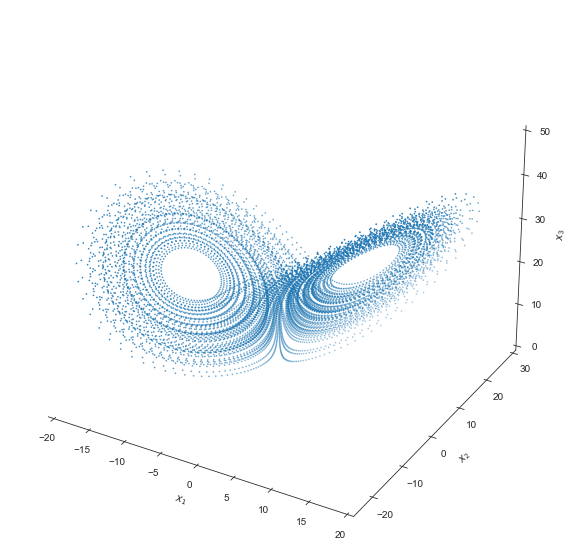

In [7]:
%matplotlib inline
# -- Graphical representation of a L63 orbit. 
plot_3d_timeseries(zt0[-10000:, :], scatter=True)

#### Computing the learning orbit (n_samples = 10,000)

In [8]:
z_0 = zt0[-1, :] # initial condition from reference orbit
n_samples = 10000 # total training samples n=10,000.
output = generate_data(L63, z_0, n_steps=n_samples, compute_y=True)
zt, dzt = np.squeeze(output['x']), np.squeeze(output['y'])

#### Building random train/test subsets from the learning orbit

In [9]:
# -- Building random train/test subsets
norm = True            # True if subsets to normalize.

# If subsets are normalized, their mean value =0 and standard derviation =1. 
if norm:
    mean_z, mean_dz = np.mean(zt, axis=0), np.mean(dzt, axis=0)
    std_z, std_dz = np.std(zt, axis=0), np.std(dzt, axis=0)
    norms_L63 = [mean_z, mean_dz, std_z, std_dz]

    zt_norm = (zt-mean_z)/std_z
    dzt_norm = (dzt-mean_dz)/std_dz

#### Setting up ANN

In [11]:
# -- Setting up NN model
layers = [256] + 5*[128] + [64, 32]       # Layers with the number of nodes on each one.
epochs = 50                               # Number of learning epochs.

# -- Building ANN 
nn_dict = {'name': 'f_orb', 'in_dim':L63.ndim, 'out_dim':L63.ndim, 'nlays':layers, 'epochs':epochs, 'norms':norms_L63}
nn_L63_orb = ML_model(nn_dict)
train_ML_model(zt_norm, dzt_norm, nn_L63_orb, batch_size=32, n_epochs=epochs)

training f_orb model...


#### Evaluation
The performance of the ANN model is assessed by integrating predicted time derivatives over `n_steps` timesteps. The starting point is randomly generated `z0`. 

In [12]:
# -- Setting up evaluation - parameters.
z0_ind = np.random.randint(N_s-N_i)       
z0 = zt0[z0_ind]         # Initial condition value.
n_steps = 20000          # Length of integration, in timesteps.
dt = 0.05                # timestep value

In [13]:
%%time
# -- Integration of L63 equations.
# -- Computing validation orbits from initial condition z0 by

# (1) integrating f (zt_L63)
output = generate_data(L63, z0, n_steps=n_steps, dt=dt, compute_y=False)
zt_L63 = np.squeeze(output['x'])

# (2) integrating f_orb (zML_L63)
output = generate_data(nn_L63_orb, z0, n_steps=n_steps, dt=dt, compute_y=False)
zML_L63 = np.squeeze(output['x'])

CPU times: user 5min 1s, sys: 23.9 s, total: 5min 24s
Wall time: 5min 32s


The plots below allows the comparison between the "actual" orbit, resulting from the integration of eL63 equations, and the integration of $\widehat{f}_{orb}$.

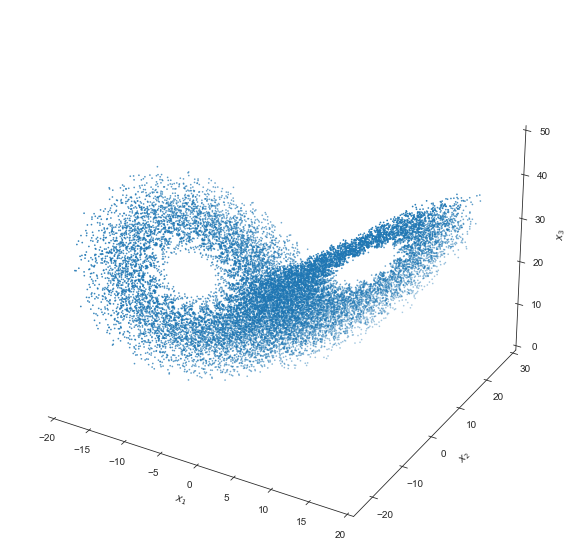

In [14]:
plot_3d_timeseries(zt_L63, scatter=True)

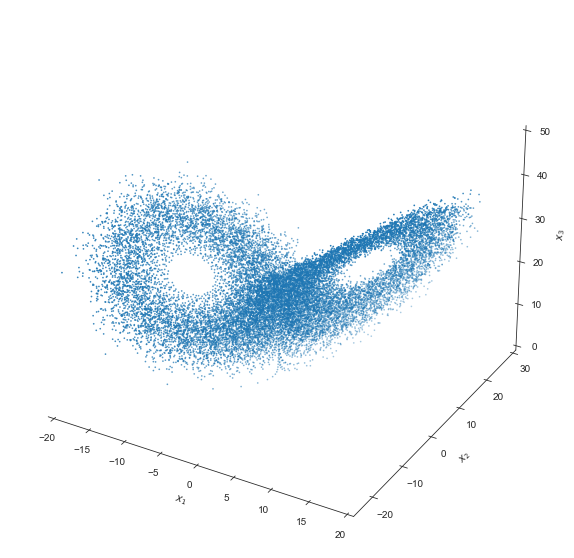

In [15]:
plot_3d_timeseries(zML_L63, scatter=True)

Stability is then assessed by verifying that the resulting orbit remains between the boundaries previously defined with the 'reference' orbit. 

In [20]:
a = 3
delta = np.max(zt0, axis=0) - np.min(zt0, axis=0)
mini = np.min(zt0, axis=0) - a*delta
maxi = np.max(zt0, axis=0) + a*delta

is_stable(zML_L63, mini, maxi)

True

## 2. Learning eL63 dynamics from a single orbit - example for $d=5$

We focus now on learning eL63 model when $d=5$, from a single orbit. The following section is organized as previously. As opposed to learning L63 dynamics, learning of eL63 will be performed in $\mathcal{B}_x$ (in the case of L63, learning was performed in $\mathcal{B}_z$).

The value of $\kappa$ is set to 1.

### 2.1 "Reference" orbit
This "reference" orbit will be used to estimate the intervals where an orbit is considered stable. These intervals can be defined with minimal and maximal values of the 'reference' orbit, `minval` and `maxval` respectively. It is also used to compute a collection of initial conditions for evaluation.

In [21]:
ndim = 5
aleamat = True

dic_LZ = {'aleamat':aleamat, 'ndim':ndim, 'sigma':10., 'beta':8./3., 'rho':28., 'kappa':1.}
eL63 = embeddedLorenz63(dic=dic_LZ)  

x_0 = np.random.rand(eL63.ndim)

dt0 = 0.01
N_s = int(1000*1./dt0)
N_i = int(100*1./dt0)
output = generate_data(eL63, x_0, n_steps=N_s, dt=dt0, compute_y=False)
xt_ref = output['x']
xt_ref = xt_ref[N_i:, 0, :]
minval_eL63 = np.min(xt_ref, axis=0)
maxval_eL63 = np.max(xt_ref, axis=0)

Stability of the resulting model can be evaluated in $\mathcal{B}_x$. Given $\left[x\right]=(x_1, x_2, ..., x_d)_N$ the orbit from which train and test dataset has been built, one can define intermediate variables $m_i, M_i$ and $\Delta$ by :
\begin{equation}
  \begin{aligned}
    \forall~~ 1 \leq i \leq d, ~m_i,M_i & = \min\left[x_i \right],~\max\left[x_i \right] \\
    \Delta_i & = M_i - m_i
  \end{aligned}
\end{equation}

An ANN model validation orbit of length $N \geq 10,000$ timesteps is considered stable if it verifies **stability criterion** that can be expressed as follows, for any validation orbit $\left[\mathbf{x}^{orb}\right] = \left[ x_1^{orb}, x_2^{orb}, ..., x_d^{orb} \right]$ : 
\begin{equation}
  \begin{aligned}
        \forall ~0<i\leq d,~\forall~x_i \in \left[ x_i^{orb}\right],~~ m_i-a\Delta_i \leq x_i \leq M_i+a\Delta_i,
  \end{aligned}
  \label{eq:stab} \tag{4}
\end{equation}
where $a=3$. 

In [22]:
# -- For further evaluation of stability
a = 3
delta = maxval_eL63 - minval_eL63
mini = minval_eL63 - a*delta
maxi = maxval_eL63 + a*delta

### 2.2 Learning eL63 from a single orbit

The first learning sample consists in a single orbit. eL63 dynamics are learnt upon a single trajectory, the same way as for L63 model at the beginning of the notebook.

In [23]:
x_0 = xt_ref[-1, :]
N_s = 10000

output = generate_data(eL63, x_0, n_steps=N_s, normalization=True)
    
xt_orb, dxt_orb = np.squeeze(output['x']), np.squeeze(output['y'])
xt_orb_norm, dxt_orb_norm = np.squeeze(output['x_norm']), np.squeeze(output['y_norm'])
norms_orb = output['norms']

#### Setting up ANN

The resulting function learned from the single training orbit, according to Eq. (3), will be noted $\hat{f}_{orb}$.

In [24]:
# -- Setting up NN model
layers = [256] + 5*[128] + [64, 32]       # Layers with the number of nodes on each one.
epochs = 50                               # Number of learning epochs.

# -- Building ANN 
nn_dict = {'name':'f_orb', 'in_dim':eL63.ndim, 'out_dim':eL63.ndim, 'nlays':layers, 'epochs':epochs, 
          'norms':norms_orb}
nn_eL63_orb = ML_model(nn_dict)
train_ML_model(xt_orb_norm, dxt_orb_norm, nn_eL63_orb, batch_size=32, n_epochs=epochs)

training f_orb model...


#### Evaluation

An orbit of length $N_{val}=1000$ MTU or 20,000 timesteps is generated from an initial condition that has been randomly sampled from the 'reference' orbit. 

The execution of the following cell may take some time. 

In [25]:
# -- Setting up evaluation - parameters.

# 3 random initial conditions (x0)
i = np.trunc((xt_ref.shape[0])*np.random.rand(3))
x0 = xt_ref[i.astype(int), ...]

n_steps = 20000               # Length of integration, in timesteps.
dt = 0.05

In [26]:
%%time
# -- Integration of eL63 equations.
# -- Computing validation orbits from initial conditions x0 by

# (1) integrating f (x_eL63)
output = generate_data(eL63, x0, n_steps=n_steps, dt=dt, compute_y=False)
x_eL63 = output['x']

# (2) integrating f_orb (xML_eL63_orb)
output = generate_data(nn_eL63_orb, x0, n_steps=n_steps, dt=dt, compute_y=False)
xML_eL63_orb = output['x']

CPU times: user 5min 24s, sys: 25 s, total: 5min 49s
Wall time: 6min 14s


In [27]:
# from B_x space to B_z space
zML_eL63_orb = eL63.Bx_to_Bz(xML_eL63_orb)
z_eL63 = eL63.Bx_to_Bz(x_eL63)

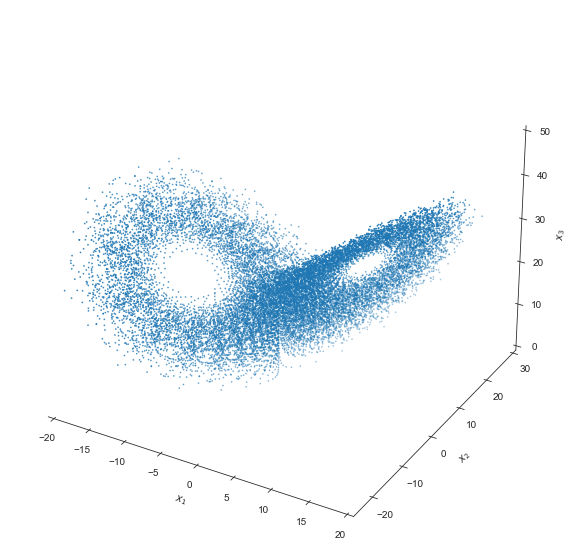

In [28]:
plot_3d_timeseries(z_eL63[:, 0, :3], scatter=True)

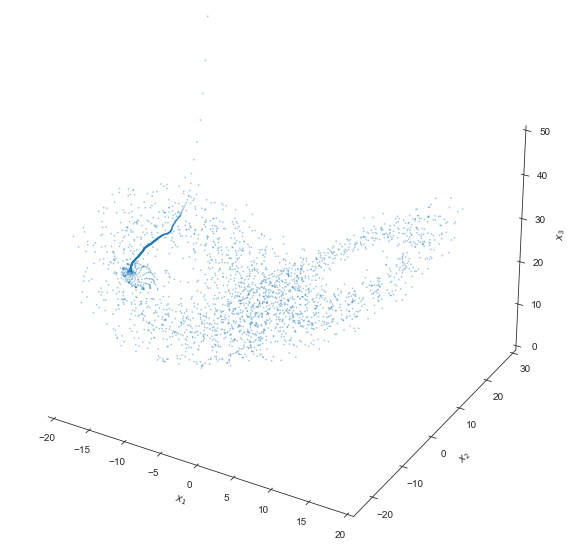

In [29]:
plot_3d_timeseries(zML_eL63_orb[~np.isnan(zML_eL63_orb[:,0,0])][:,0,:3], scatter=True)

#### Stability

In [38]:
is_stable(xML_eL63_orb, mini, maxi)

False

In [39]:
diag_fixed_points(xML_eL63_orb[:, 0, :])

False

### 2.3 Step 3 : learning from a dataset generated by Latin Hypercube Sampling (LHS)

A single orbit as a learning set can be seen as degenerated ; thus instability issues can be seen as an **out-of-distribution** problem. Here we test the idea of learning from a training dataset including a region around eL63 attractors, with Latin Hypercube Sampling (LHS). 

To compare learning from different datasets (i.e. a single orbit or LHS sample), the ANN architecture will remain the same as in the previous section. LHS sample size will also match training orbit length of $N=10,000$. Validation orbits will be generated from the same initial conditions than in the previous section. 

#### Building random train/test subsets from an LHS sample

In [40]:
N_s = 10000      # Total training samples n=10,000.
norm = True            # True if subsets to normalize.

# -- Creating LHS learning dataset in B_X
x_lhs, dx_lhs, x_norm_lhs, dx_norm_lhs, norms_lhs = generate_LHS(eL63, minval_eL63, 
                                                                 maxval_eL63, 
                                                                 n_samples=N_s)

#### Setting up ANN

eL63 dynamics learned from an LHS generated sample will build function $\hat{f}^{LHS}$ that will be compared with $\hat{f}^{orb}$.

In [41]:
layers = [256] + 5*[128] + [64, 32]       # Layers with the number of nodes on each one.
epochs = 50   

dic_NN = {'name':'f_lhs', 'in_dim':eL63.ndim, 'out_dim':eL63.ndim, 'nlays':layers, 
          'norms':norms_lhs}
nn_eL63_lhs = ML_model(dic_NN)
train_ML_model(x_norm_lhs, dx_norm_lhs, nn_eL63_lhs, batch_size=32, n_epochs=epochs)

training f_lhs model...


R2 scores associated with $\hat{f}_{LHS}$ are slightly below those of $\hat{f}_{orb}$ during fitting. In fact, this is not surprising as the region of $\mathcal{B}_x$ covered by $\hat{f}_{LHS}$ is greater than the single orbit from which $\hat{f}_{orb}$ has learned eL63 dynamics.

#### Evaluation 

In [42]:
%%time
# integrating f_lhs (xML_eL63_lhs) from initial condition x0
output = generate_data(nn_eL63_lhs, x0, n_steps=n_steps, dt=dt, compute_y=False)
xML_eL63_lhs = output['x']

zML_eL63_lhs = eL63.Bx_to_Bz(xML_eL63_lhs)

CPU times: user 4min 43s, sys: 23.1 s, total: 5min 7s
Wall time: 4min 47s


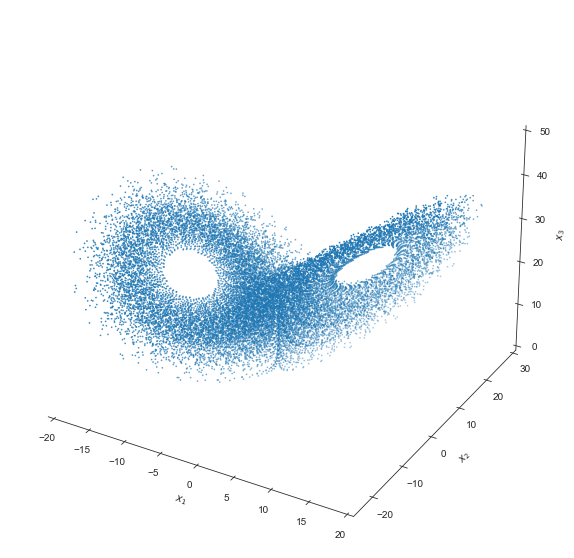

In [43]:
plot_3d_timeseries(zML_eL63_lhs[:, 0, :3], scatter=True)

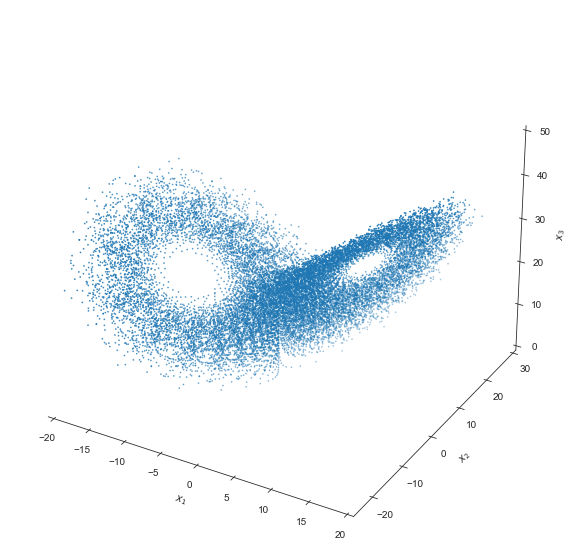

In [44]:
plot_3d_timeseries(z_eL63[:, 0, :3], scatter=True)

#### Stability

In [45]:
is_stable(xML_eL63_lhs, mini, maxi)

True

In [46]:
diag_fixed_points(xML_eL63_lhs[:, 0, :])

False

#### Comparing the distribution of $z_{i}(t)$

In [47]:
import pandas as pd

df_eL63 = save_orbits(x_eL63.reshape(1, *x_eL63.shape), [('_', 'n/a')], eL63.name, eL63_model=eL63)
df_orb = save_orbits(xML_eL63_orb.reshape(1, *xML_eL63_orb.shape), [('_', 'n/a')], nn_eL63_orb.name, eL63_model=eL63)
df_lhs = save_orbits(xML_eL63_lhs.reshape(1, *xML_eL63_lhs.shape), [('_', 'n/a')], nn_eL63_lhs.name, eL63_model=eL63)

In [48]:
df_plot = pd.concat([df_eL63, df_orb, df_lhs])

<Figure size 432x288 with 0 Axes>

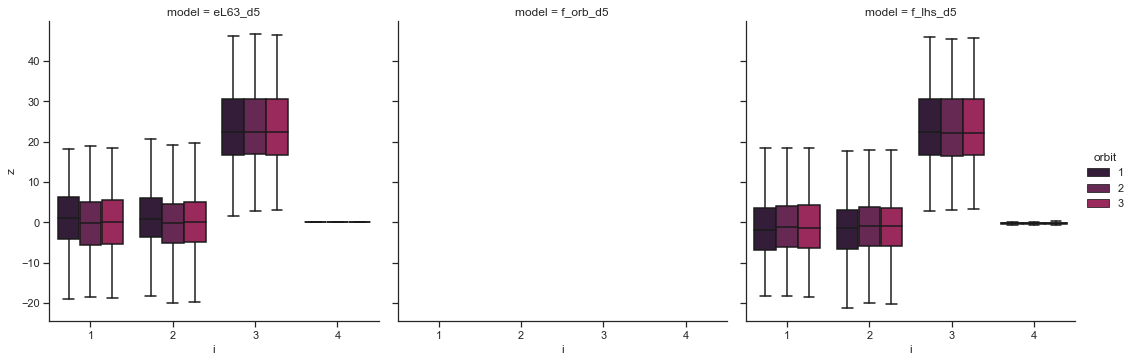

In [49]:
plot_orbits_distribution(df_plot, 'title', 'fig', 'png')